In [1]:
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import nibabel.processing as nibpro
import SimpleITK as sitk
import json
import matplotlib.patches as mpatches
from pathlib import Path
from PIL import Image, ImageEnhance
from matplotlib import cm
import matplotlib
import re
if not str(Path("../..").resolve()) in sys.path:
    sys.path.append(str(Path("../..").resolve()))
from slice_inflate.datasets.align_mmwhs import nifti_transform, cut_slice, crop_around_label_center

### Prepare MMWHS: Orient main volume by Slicer3D view

In [2]:
def plot_slices(red_slice, green_slice, yellow_slice, vmin=0.0, vmax=1.0):
    fig_img = plt.figure()
    new_plot = fig_img.add_subplot(131)
    plt.imshow(red_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(132)
    plt.imshow(green_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)
    new_plot = fig_img.add_subplot(133)
    plt.imshow(yellow_slice.T.flip([1,0]), cmap='gray', vmin=vmin, vmax=vmax)

    axs = fig_img.axes
    axs[0].set_title("red")
    axs[1].set_title("green")
    axs[2].set_title("yellow")
    plt.show()

In [3]:
mmwhs_base_path = "../../data/MMWHS"

mri_1002_nii = nib.load(Path(mmwhs_base_path, "mr_test_selection/mr_train_1002_image.nii.gz"))
mri_1002_gt_nii = nib.load(Path(mmwhs_base_path, "mr_test_selection/mr_train_1002_label.nii.gz"))

red_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_HLA_red_slice_to_ras.mat"))
yellow_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_yellow_slice_to_ras.mat"))

FOV_MM = torch.tensor([300,300,300])
FOV_VOX = torch.tensor([200,200,200])
# CROP_SIZE = torch.tensor([128,128,-1])

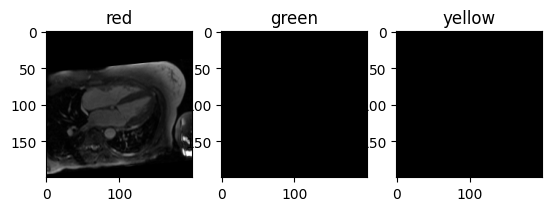

In [4]:
red_volume, red_affine = nifti_transform(
    torch.as_tensor(mri_1002_nii.get_fdata()), 
    torch.as_tensor(mri_1002_nii.affine), 
    red_slice_to_ras_mat, 
    fov_mm=FOV_MM, 
    fov_vox=FOV_VOX)

red_label, _ = nifti_transform(
    torch.as_tensor(mri_1002_gt_nii.get_fdata()), 
    torch.as_tensor(mri_1002_gt_nii.affine), 
    red_slice_to_ras_mat, fov_mm=FOV_MM, 
    fov_vox=FOV_VOX, is_label=True)

# red_label, red_volume, red_affine = \
#     crop_around_label_center(red_label, vox_size=CROP_SIZE, image=red_volume, affine=red_affine)

ref_img_path = Path(mmwhs_base_path, "preprocessed/train_HLA_4_chamber/mr_train_1002_image_HLA.nii.gz")
ref_label_path = Path(mmwhs_base_path, "preprocessed/train_HLA_4_chamber/mr_train_1002_label_HLA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)

nib.save(nib.Nifti1Image(red_volume.numpy(), affine=red_affine), ref_img_path)
nib.save(nib.Nifti1Image(red_label.int().numpy(), affine=red_affine), ref_label_path)

red_slice = cut_slice(red_volume)
plot_slices(red_slice, torch.zeros_like(red_slice), torch.zeros_like(red_slice), vmax=red_volume.max().item())

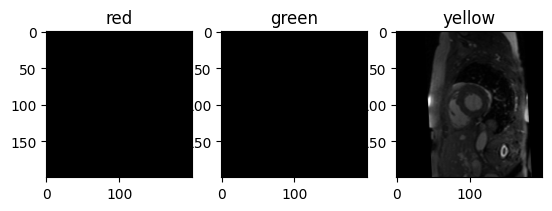

In [5]:
yellow_volume, yellow_affine = nifti_transform(
    torch.as_tensor(mri_1002_nii.get_fdata()), 
    torch.as_tensor(mri_1002_nii.affine), 
    yellow_slice_to_ras_mat, 
    fov_mm=FOV_MM, 
    fov_vox=FOV_VOX)

yellow_label, _ = nifti_transform(
    torch.as_tensor(mri_1002_gt_nii.get_fdata()), 
    torch.as_tensor(mri_1002_gt_nii.affine), 
    yellow_slice_to_ras_mat, fov_mm=FOV_MM, 
    fov_vox=FOV_VOX, is_label=True)

# yellow_label, yellow_volume, yellow_affine = \
#     crop_around_label_center(yellow_label, vox_size=CROP_SIZE, image=yellow_volume, affine=yellow_affine)

ref_img_path = Path(mmwhs_base_path, "preprocessed/train_SA/mr_train_1002_image_SA.nii.gz")
ref_label_path = Path(mmwhs_base_path, "preprocessed/train_SA/mr_train_1002_label_SA.nii.gz")
ref_img_path.parent.mkdir(exist_ok=True, parents=True)

nib.save(nib.Nifti1Image(yellow_volume.numpy(), affine=yellow_affine), ref_img_path)
nib.save(nib.Nifti1Image(yellow_label.int().numpy(), affine=yellow_affine), ref_label_path)

yellow_slice = cut_slice(yellow_volume)
plot_slices(torch.zeros_like(yellow_slice), torch.zeros_like(yellow_slice), yellow_slice, vmax=yellow_volume.max().item())

### Prepare MMWHS: Reorient volumes based on 1002 fixed labels with c3d and store as modified volume

In [6]:
mmwhs_base_path = "../../data/MMWHS"

c3d = "/share/data_supergrover1/weihsbach/shared_data/tmp/c3d/c3d-1.1.0-Linux-gcc64/bin/c3d"

FIXED_ID = 1002
moving_ids = list(range(1001, 1021, 1))

fixed_label_filepath = Path(mmwhs_base_path, "mr_test_selection", f"mr_train_{FIXED_ID}_label.nii.gz")
fixed_image_filepath = Path(mmwhs_base_path, "mr_test_selection", f"mr_train_{FIXED_ID}_image.nii.gz")

DOF = 6
# USE_NNUNET_NAMES = False

for vieww in ["SA", "HLA"]:
    for mod in ["CT", "MR"]:
        s_dir = "train"
        print(f"Registering view '{vieww}' for modality '{mod}'")

        for m_id in moving_ids:

            affine_path = Path(mmwhs_base_path, "preprocessed", f"f{FIXED_ID}mr_m{m_id}{mod.lower()}.mat")
            affine_path.parent.mkdir(exist_ok=True, parents=True)

            moving_image_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_image.nii.gz")
            moving_label_filepath = Path(mmwhs_base_path, f"{mod.lower()}_train", f"{mod.lower()}_train_{m_id}_label.nii.gz")

            if not (moving_image_filepath.is_file() and moving_label_filepath.is_file()): 
                moving_image_filepath = Path(mmwhs_base_path, f"{mod.lower()}_test_selection", f"{mod.lower()}_train_{m_id}_image.nii.gz")
                moving_label_filepath = Path(mmwhs_base_path, f"{mod.lower()}_test_selection", f"{mod.lower()}_train_{m_id}_label.nii.gz")

            print(f"Transforming {m_id} to {FIXED_ID}")
            print(affine_path)
            
            !{c3d} {fixed_label_filepath} {moving_label_filepath} -align-landmarks {DOF} {affine_path}

Registering view 'SA' for modality 'CT'
Transforming 1001 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1001ct.mat
Transforming 1002 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1002ct.mat
Transforming 1003 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1003ct.mat
Transforming 1004 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1004ct.mat
Transforming 1005 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1005ct.mat
Transforming 1006 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1006ct.mat
Transforming 1007 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1007ct.mat
Transforming 1008 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1008ct.mat
Transforming 1009 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1009ct.mat
Transforming 1010 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1010ct.mat
Transforming 1011 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1011ct.mat
Transforming 1012 to 1002
../../data/MMWHS/preprocessed/f1002mr_m1012ct.mat
Transforming 1013 to 1002
../../data/MMWHS/prepr

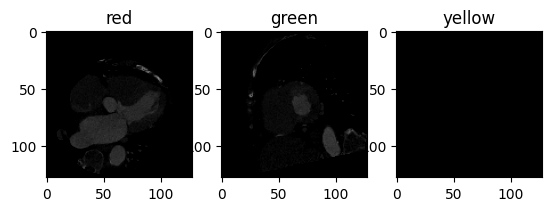

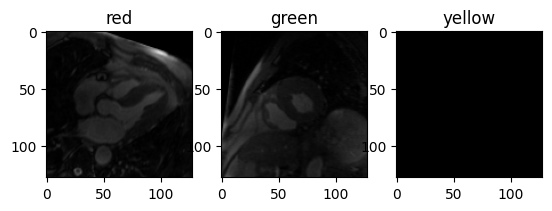

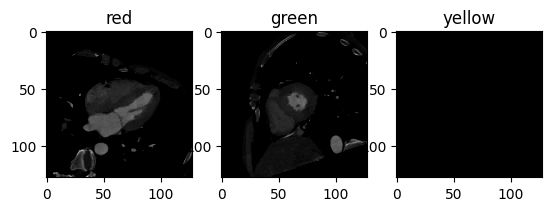

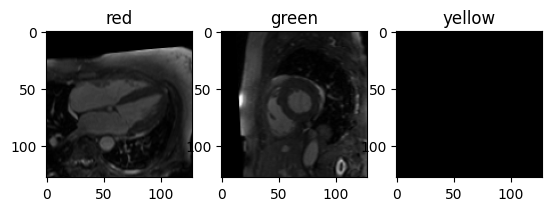

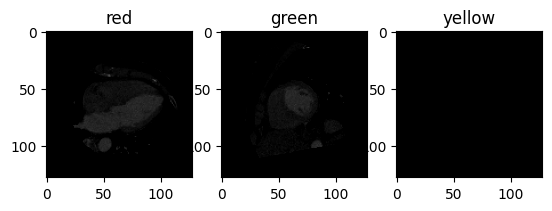

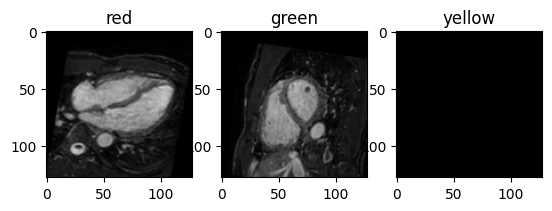

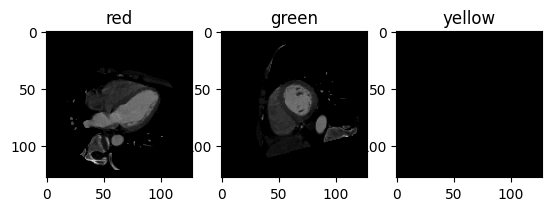

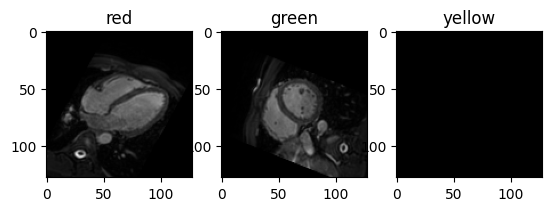

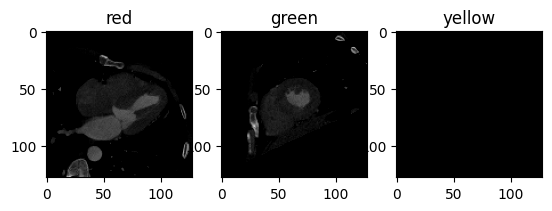

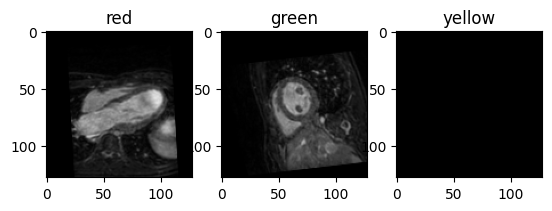

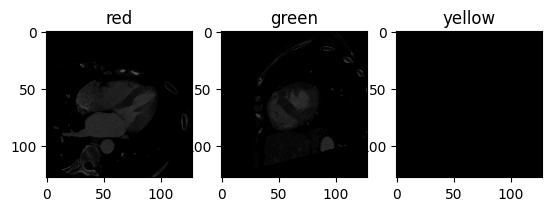

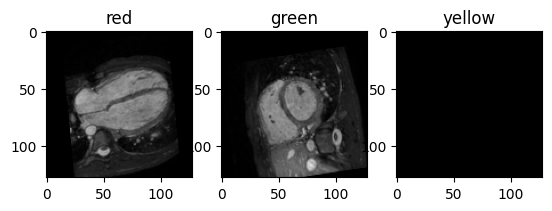

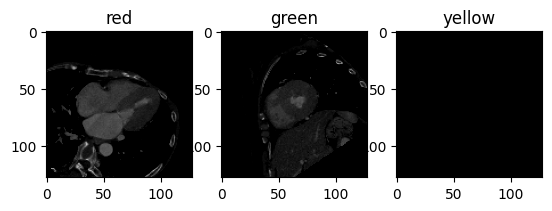

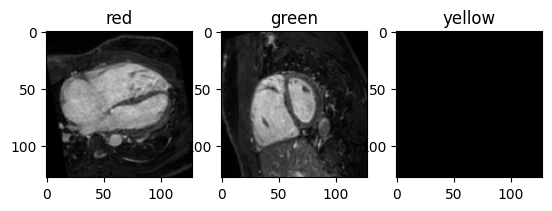

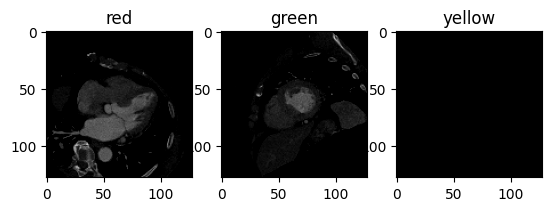

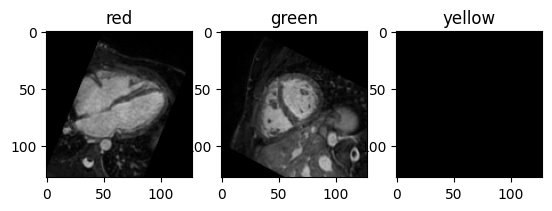

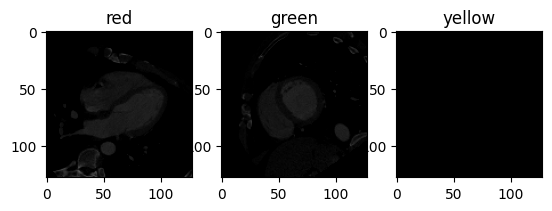

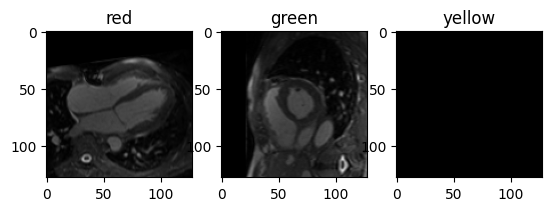

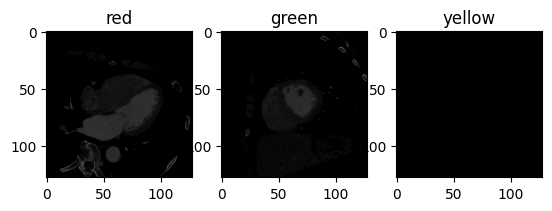

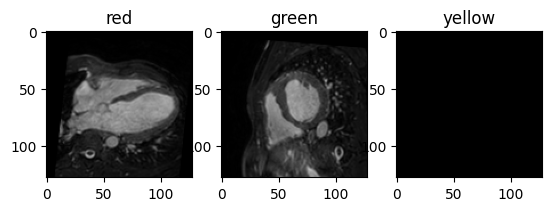

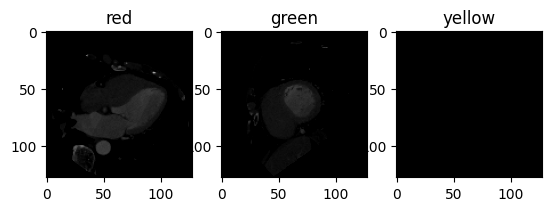

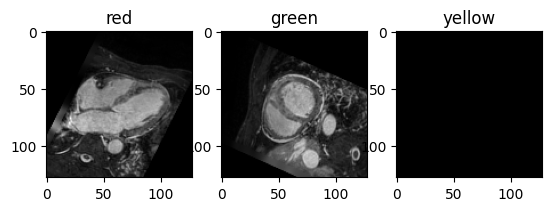

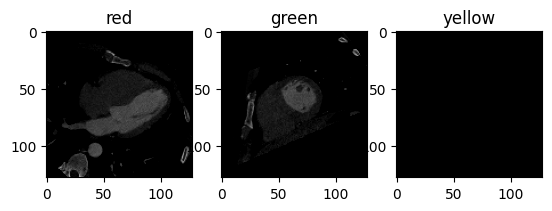

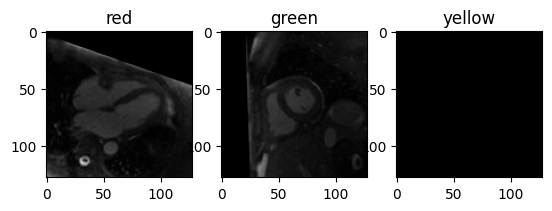

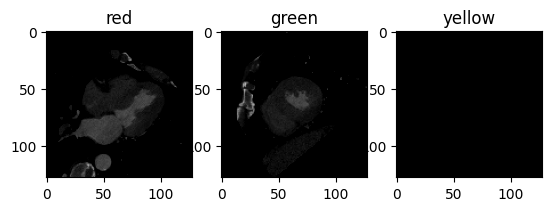

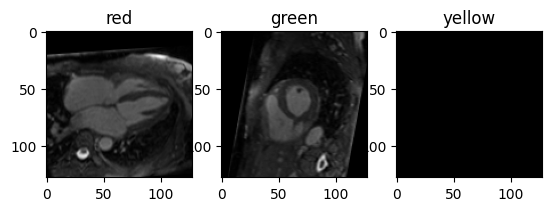

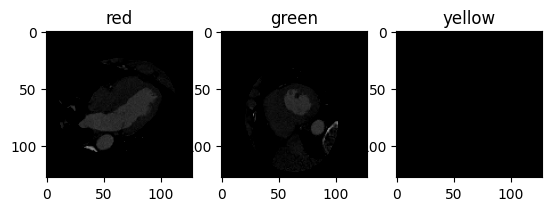

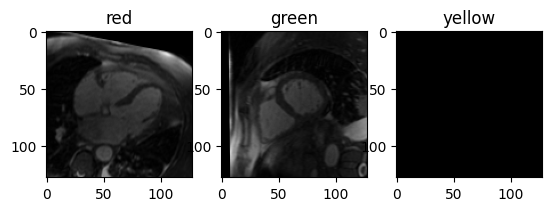

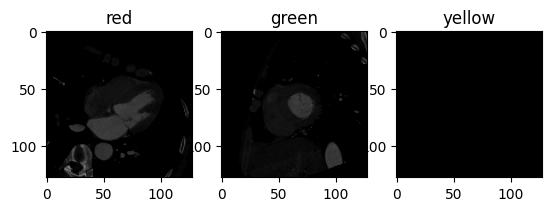

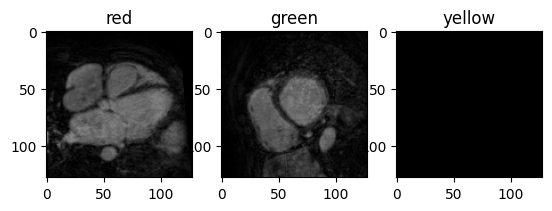

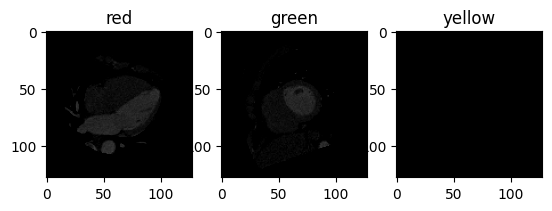

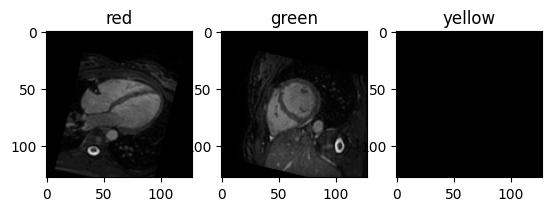

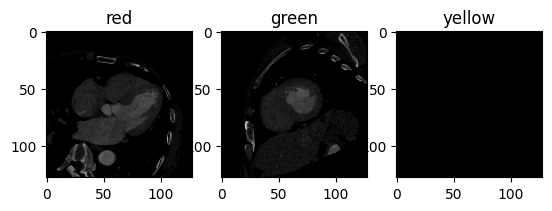

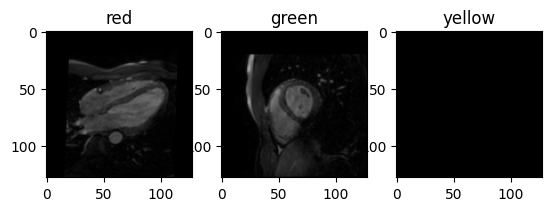

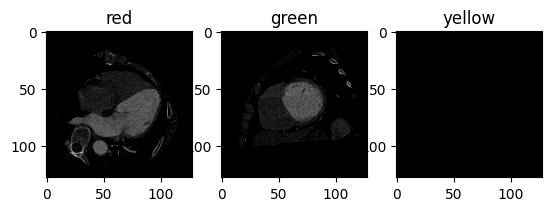

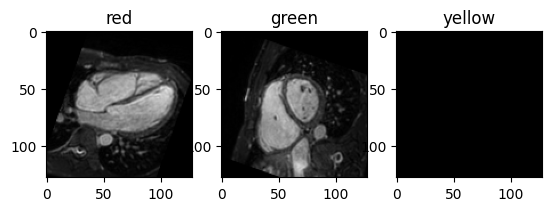

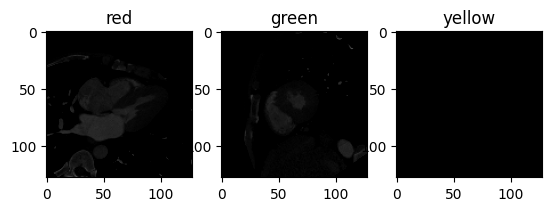

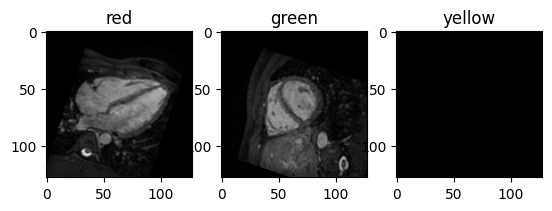

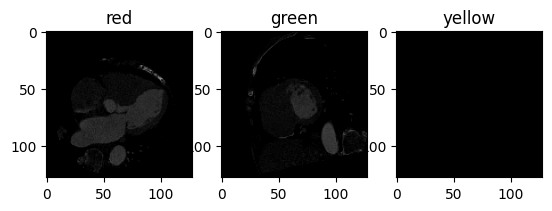

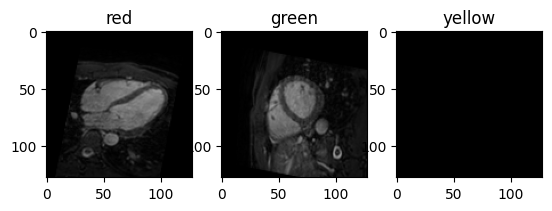

In [10]:
mmwhs_base_path = "../../data/MMWHS"

red_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_HLA_red_slice_to_ras.mat"))
yellow_slice_to_ras_mat = torch.from_numpy(np.loadtxt("./mmwhs_1002_SA_yellow_slice_to_ras.mat"))

FOV_MM = torch.tensor([224,224,224])
FOV_VOX = torch.tensor([128,128,128])

for p_id in range(1001,1021):
    for mod_id in ['ct', 'mr']:
        mri_path = Path(mmwhs_base_path, f"{mod_id}_train/{mod_id}_train_{p_id}_image.nii.gz")
        mri_gt_path = Path(mmwhs_base_path, f"{mod_id}_train/{mod_id}_train_{p_id}_label.nii.gz")

        if not (mri_path.is_file() and mri_gt_path.is_file()): 
            mri_path = Path(mmwhs_base_path, f"{mod_id}_test_selection/{mod_id}_train_{p_id}_image.nii.gz")
            mri_gt_path = Path(mmwhs_base_path, f"{mod_id}_test_selection/{mod_id}_train_{p_id}_label.nii.gz")

        nii = nib.load(mri_path)
        gt_nii = nib.load(mri_gt_path)

        align_mat = torch.from_numpy(np.loadtxt(f"/share/data_supergrover1/weihsbach/shared_data/tmp/slice_inflate/data/MMWHS/preprocessed/f1002mr_m{p_id}{mod_id}.mat"))
        hla_mat = align_mat @ red_slice_to_ras_mat
        sa_mat =  align_mat @ yellow_slice_to_ras_mat

        data = torch.as_tensor(nii.get_fdata())
        gt_data = torch.as_tensor(gt_nii.get_fdata())
        affine = torch.as_tensor(nii.affine)
        gt_affine = torch.as_tensor(gt_nii.affine)

        hla_volume, _ = nifti_transform(data, affine, hla_mat, fov_mm=FOV_MM, fov_vox=FOV_VOX)
        hla_label, _ = nifti_transform(gt_data, gt_affine, hla_mat, fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)
        sa_volume, _ = nifti_transform(data, affine, sa_mat, fov_mm=FOV_MM, fov_vox=FOV_VOX)
        sa_label, _ = nifti_transform(gt_data, gt_affine, sa_mat, fov_mm=FOV_MM, fov_vox=FOV_VOX, is_label=True)

        hla_slc = cut_slice(hla_volume)
        sa_slc = cut_slice(sa_volume)

        plot_slices(hla_slc, sa_slc, torch.zeros_like(sa_slc), vmax=hla_volume.max().item())